## From Assembly to Serial (and back)

**2a. Apply the Shang-Song heuristic to find the right basestock policy (echelon type)**. 

Make sure you plot three curves:
* A. The approximative solution.
* L. The lower bound.
* U. The upper bound.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [34]:
def get_heuristic(
    stages: list[int],
    local_holding_costs: list[int],
    lead_times: list[int],
    penalty: int,
    mu: int,
    sigma: int,
) -> dict[int, dict[str, float]]:
    results = {stage: {} for stage in stages}
    for idx, stage in enumerate(stages):
        lead_time_scale = sum(lead_times[: idx + 1])
        lower_bound_ratio = (penalty + sum(local_holding_costs[idx + 1 :])) / (
            penalty + sum(local_holding_costs)
        )
        lower_bound = mu * lead_time_scale + norm.ppf(
            lower_bound_ratio
        ) * sigma * np.sqrt(lead_time_scale)
        upper_bound_ratio = (penalty + sum(local_holding_costs[idx + 1 :])) / (
            penalty + sum(local_holding_costs[idx:])
        )
        upper_bound = mu * lead_time_scale + norm.ppf(
            upper_bound_ratio
        ) * sigma * np.sqrt(lead_time_scale)
        results[stage]["upper"] = upper_bound
        results[stage]["lower"] = lower_bound
        results[stage]["approx"] = (upper_bound + lower_bound) / 2
    return results

In [35]:
stages = [1, 2, 3]
local_holding_costs = [3, 2, 2]
lead_times = [1, 1, 2]
penalty = 37.12
mu = 5
sigma = 1
heuristic_results = get_heuristic(stages, local_holding_costs, lead_times, penalty, mu, sigma)
for stage in stages:
    print(
        f"Stage {stage}: {heuristic_results[stage]['lower']} <= S^*_{stage} <= {heuristic_results[stage]['upper']}"
    )

Stage 1: 6.490880975286938 <= S^*_1 <= 6.490880975286938
Stage 2: 11.709814628606217 <= S^*_2 <= 12.34505481804949
Stage 3: 21.999975609063505 <= S^*_3 <= 23.268089174509065


In [ ]:
stages = [1, 2, 3, 4, 5]
local_holding_costs = [3, 4, 3, 0, 0]
lead_times = [1, 2, 1, 1, 1]
penalty = 5
mu = 5
sigma = 1
heuristic_results = get_heuristic(stages, local_holding_costs, lead_times, penalty, mu, sigma)
for stage in stages:
    print(
        f"Stage {stage}: {heuristic_results[stage]['lower']} <= S^*_{stage} <= {heuristic_results[stage]['upper']}"
    )

Stage 1: 5.841621233572914 <= S^*_1 <= 5.841621233572914
Stage 2: 15.144889053268379 <= S^*_2 <= 15.746041566586658
Stage 3: 19.138545401409086 <= S^*_3 <= 20.63727872792875
Stage 4: 24.03686447901046 <= S^*_4 <= inf
Stage 5: 38.78171922330406 <= S^*_5 <= inf


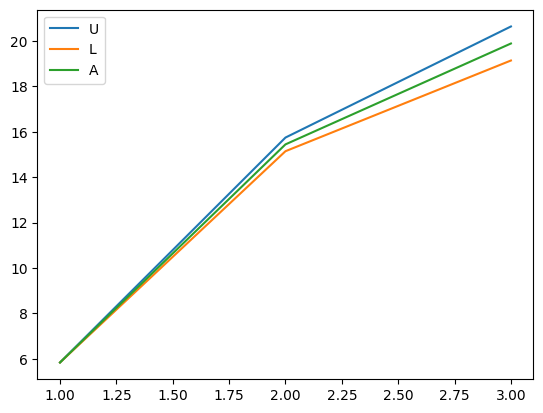

In [37]:
upper_bounds = [heuristic_results[stage]["upper"] for stage in stages[:3]]
lower_bounds = [heuristic_results[stage]["lower"] for stage in stages[:3]]
approx = [heuristic_results[stage]["approx"] for stage in stages[:3]]
plt.plot(stages[:3], upper_bounds, label="U")
plt.plot(stages[:3], lower_bounds, label="L")
plt.plot(stages[:3], approx, label="A")
plt.legend()

**2b. In addition, compute the exact solution (S) for each echelon and add it to the plot of 2a. Does it fall within the range outlined by the heuristic (i.e., between L and U)?**

In [38]:
from typing import Callable


def c_hat(holding_cost, last_c_under) -> Callable[[float], float]:
    return lambda x: holding_cost * x + last_c_under(x)

def c(c_hat_func, mu, sigma) -> Callable[[float], float]:
    def expected_value(y):
        return norm.expect(lambda x: c_hat_func(y-x), loc=mu, scale=sigma)
    return expected_value

def c_under(c_hat_func, S_star) -> Callable[[float], float]:
    return lambda x: c_hat_func(min(S_star, x))

In [39]:
from tqdm import tqdm
def get_exact(
    stages: list[int],
    local_holding_costs: list[int],
    lead_times: list[int],
    penalty: int,
    mu: int,
    sigma: int,
    use_heuristic: bool = False
) -> dict[int, float]:
    C_under = {0: lambda x: max(0, -x) * (penalty + sum(local_holding_costs))}
    C_hat = {}
    C = {}
    S_star: dict[int, float] = {}
    if use_heuristic:
        heuristic_results = get_heuristic(stages, local_holding_costs, lead_times, penalty, mu, sigma)
    for idx, j in tqdm(enumerate(stages)):
        C_hat[j] = c_hat(local_holding_costs[idx], C_under[j - 1])
        lead_time_scale = sum(lead_times[: idx + 1])
        C[j] = c(C_hat[j], mu * lead_time_scale, sigma * np.sqrt(lead_time_scale))
        if use_heuristic:
            possible_y_values = np.linspace(heuristic_results[j]["lower"], heuristic_results[j]["upper"], 101)
        else:
            possible_y_values = np.linspace(0, 100, 51)
            # Get an estimate of S_star
            temp_S_star = possible_y_values[np.argmin([C[j](y) for y in possible_y_values])]
            # Get more precise S_star
            possible_y_values = np.linspace(temp_S_star - 1, temp_S_star + 1, 101) 
            temp_S_star = possible_y_values[np.argmin([C[j](y) for y in possible_y_values])]
            possible_y_values = np.linspace(temp_S_star - 0.1, temp_S_star + 0.1, 101)
        S_star[j] = possible_y_values[np.argmin([C[j](y) for y in possible_y_values])]
        C_under[j] = c_under(C_hat[j], S_star[j])
    return S_star 

In [ ]:
stages = [1, 2, 3, 4, 5]
local_holding_costs = [3, 4, 3, 0, 0]
lead_times = [1, 2, 1, 1, 1]
penalty = 5
mu = 5
sigma = 1
exact_results = get_exact(stages, local_holding_costs, lead_times, penalty, mu, sigma, use_heuristic=True)
exact_results

3it [00:19,  6.56s/it]b:\Documents\Skola\UvA\Y4P2\Supply Chain\.venv\Lib\site-packages\numpy\_core\function_base.py:169: RuntimeWarning: invalid value encountered in multiply
  y *= step
b:\Documents\Skola\UvA\Y4P2\Supply Chain\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2996: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  lbc = integrate.quad(fun, lb, c, **kwds)[0]
b:\Documents\Skola\UvA\Y4P2\Supply Chain\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2997: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  cd = integrate.quad(fun, c, d, **kwds)[0]
b:\Documents\Skola\UvA\Y4P2\Supply Chain\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2998: IntegrationWarning: The occurrence of roundoff error is detected, w

{1: np.float64(5.841621233572914),
 2: np.float64(15.144889053268379),
 3: np.float64(19.138545401409086),
 4: np.float64(nan),
 5: np.float64(nan)}

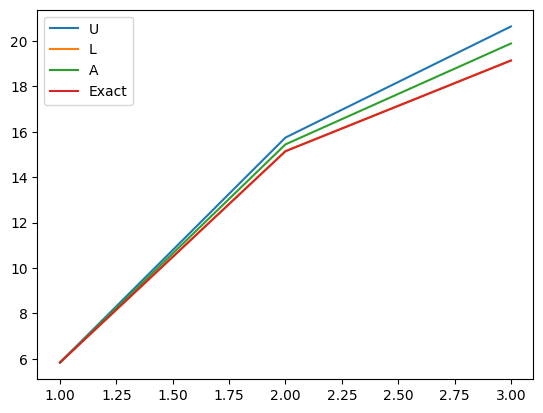

In [41]:
# Plot the exact values in comparison to the heuristic
upper_bounds = [heuristic_results[stage]["upper"] for stage in stages[:3]]
lower_bounds = [heuristic_results[stage]["lower"] for stage in stages[:3]]
approx = [heuristic_results[stage]["approx"] for stage in stages[:3]]
plt.plot(stages[:3], upper_bounds, label="U")
plt.plot(stages[:3], lower_bounds, label="L")
plt.plot(stages[:3], approx, label="A")
exact = [exact_results[stage] for stage in stages[:3]]
plt.plot(stages[:3], exact, label="Exact")
plt.legend()

## Simulating the Bullwhip Effect: Demand Signalling

**3a. For α = 0.8, plot the customer demand Di and orders of the retailer and manufacturer QRET,i and QMAN,i. So, three curves in total for one round, a round consisting of 50 days. Do you observe a bullwhip effect?**

In [42]:
from abc import ABC, abstractmethod
from typing import Callable


class Stage(ABC):
    def __init__(
        self, name: str, inventory: float, in_coming_level: float, lead_time: int
    ) -> None:
        self.name = name
        self.inventory = inventory
        self.total_orders = 0
        self.in_coming = [in_coming_level for _ in range(max(lead_time, 1))]

    # 1. Check delivery
    def check_delivery(self):
        self.inventory += self.in_coming.pop(0)

    # 2. Check orders
    def check_order(self, order: float):
        self.total_orders += order

    # 3. Deliver order -> go to transit in next stage
    def deliver_order(self) -> float:
        out = min(self.total_orders, self.inventory)
        self.total_orders -= out
        self.inventory -= out
        return out

    # 4. Make order decision
    @abstractmethod
    def make_order_decision(self) -> float: ...

    # 5. Add in transit items
    def add_in_transit(self, order: float):
        self.in_coming.append(order)

    def go_forward(self, order: float) -> tuple[float, float]:
        self.check_delivery()
        self.check_order(order)
        delivery = self.deliver_order()
        order = self.make_order_decision()
        return delivery, order

    def __repr__(self) -> str:
        return f"Stage(name={self.name:<20}, inventory={self.inventory:<15.1f}, total_orders={self.total_orders:<3.1f}, in_coming={self.in_coming})"


class BeerGame:
    def __init__(
        self,
        stage_class: type[Stage],
        weeks: int = 52,
        initial_stock: float = 20,
        demand_function: Callable[[], float] = lambda: np.random.normal(20, 4),
        lead_time: int = 4,
        **kwargs,
    ):
        self.weeks = weeks
        self.initial_stock = initial_stock
        self.demand_function = demand_function
        self.infinite_supplier = stage_class("Infinite Supplier", 1e10, 0, 0, **kwargs)
        self.manufacturer = stage_class(
            "Manufacturer", initial_stock, 20, lead_time, **kwargs
        )
        self.retailer = stage_class("Retailer", initial_stock, 20, lead_time, **kwargs)
        self.lead_time = lead_time

    def go_forward(self):
        demand = self.demand_function()

        # Step 1
        self.infinite_supplier.check_delivery()
        self.manufacturer.check_delivery()
        self.retailer.check_delivery()

        # Step 2
        self.retailer.check_order(demand)
        self.retailer.deliver_order()
        retailer_order = self.retailer.make_order_decision()

        self.manufacturer.check_order(retailer_order)
        man_produced = self.manufacturer.deliver_order()
        manufacturer_order = self.manufacturer.make_order_decision()
        self.retailer.add_in_transit(man_produced)

        self.infinite_supplier.check_order(manufacturer_order)
        inf_produced = self.infinite_supplier.deliver_order()
        self.manufacturer.add_in_transit(inf_produced)
        self.infinite_supplier.add_in_transit(
            self.infinite_supplier.make_order_decision()
        )

        return demand, retailer_order, manufacturer_order

    def simulate(self):
        simulation = {}
        for week in range(self.weeks):
            demand, retailer, manufacturer = self.go_forward()
            simulation[week] = {
                "demand": demand,
                "retailer_order": retailer,
                "manufacturer_order": manufacturer,
            }
            simulation[week]["infinite_supplier_inventory"] = (
                self.infinite_supplier.inventory
            )
            simulation[week]["infinitely_supplier_orders"] = (
                self.infinite_supplier.total_orders
            )
            simulation[week]["manufacturer_inventory"] = self.manufacturer.inventory
            simulation[week]["manufacturer_orders"] = self.manufacturer.total_orders
            simulation[week]["retailer_inventory"] = self.retailer.inventory
            simulation[week]["retailer_orders"] = self.retailer.total_orders

        return simulation

    @staticmethod
    def bullwhip_effect(sim):
        days = list(sim.keys())
        retailer_inventory = [sim[day]["retailer_order"] for day in days]
        manufacturer_inventory = [sim[day]["manufacturer_order"] for day in days]
        demand_inventory = [sim[day]["demand"] for day in days]
        return np.var(retailer_inventory) / np.var(demand_inventory), np.var(
            manufacturer_inventory
        ) / np.var(demand_inventory)

    def visualise_simulation(self, simulation):
        days = list(simulation.keys())
        demand = [simulation[day]["demand"] for day in days]
        retailer_order = [simulation[day]["retailer_order"] for day in days]
        manufacturer_order = [simulation[day]["manufacturer_order"] for day in days]
        # infinitely_supplier_orders = [simulation[day]["infinitely_supplier_orders"] for day in days]
        plt.plot(days, demand, label="Demand")
        plt.plot(days, retailer_order, label="Retailer Order")
        plt.plot(days, manufacturer_order, label="Manufacturer Order")
        plt.legend()

    def __repr__(self):
        return f"BeerGame(weeks={self.weeks}, initial_stock={self.initial_stock}, demand_function={self.demand_function}, lead_time={self.lead_time})\n{self.infinite_supplier}\n{self.manufacturer}\n{self.retailer}"

In [43]:
class RandomStage(Stage):
    def __init__(
        self, name: str, inventory: float, in_coming_level: float, lead_time: int
    ) -> None:
        super().__init__(name, inventory, in_coming_level, lead_time)
        self.last_order = in_coming_level

    def check_order(self, order: float):
        self.last_order = order
        return super().check_order(order)

    def make_order_decision(self) -> float:
        if self.last_order > 20:
            return self.total_orders / 4 * np.random.uniform(0.9, 1.3)
        return self.total_orders / 4 * np.random.uniform(0.4, 1.1)

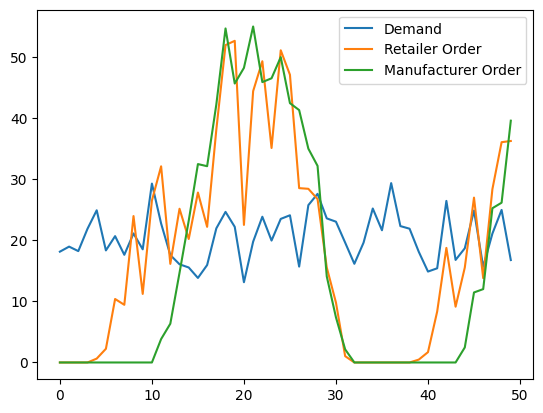

In [44]:
# Make sure it works, we react to the demand observe by ordering by the number of orders that we have recieved and not yet delivered
# We are looking at wheter or not we are observing the bullwhip effect (especially for the manufacturer)
rand_bg = BeerGame(RandomStage, weeks=50)
rand_sim = rand_bg.simulate()
rand_bg.visualise_simulation(rand_sim)

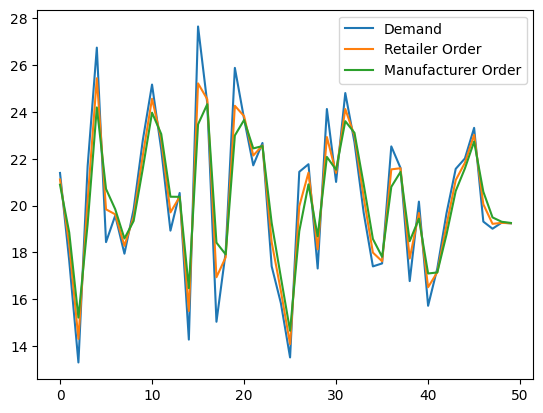

In [45]:
class ExponentialSmoothingStage(Stage):
    def __init__(
        self,
        name: str,
        inventory: float,
        in_coming_level: float,
        lead_time: int,
        alpha: float = 0.8,
    ) -> None:
        super().__init__(name, inventory, in_coming_level, lead_time)
        self.alpha = alpha
        self.forecast = inventory

    def check_order(self, order: float):
        self.forecast = self.alpha * order + (1 - self.alpha) * self.forecast
        return super().check_order(order)

    def make_order_decision(self) -> float:
        return self.forecast


exp_bg = BeerGame(ExponentialSmoothingStage, weeks=50)
exp_sim = exp_bg.simulate()
exp_bg.visualise_simulation(exp_sim)

**3b. Are demand fluctuations amplified? Name and compute a metric that quantifies the size of the bullwhip effect per stage, if there is one.**

Since the bullwhip effect causes a big deviation from the mean we will use the variance of the demand and the order levels. The ratio of $\tilde{b}=\frac{\text{Var}(\text{manufacturer order size})}{\text{Var}(\text{demand})}$ (similar for Retailer) will show wheter or not we have a bullwhip effect if the ratio is $\tilde{b}\gg 1$. Below we have emperical proof that the metric works, by seeing that in the random stage strategy we have a much higher ratio compared to the exponential smoothing.

The demand fluctations do not get amplified with the exponential smoothing for the different stages, this is because they are reacting rationally to the changes in demand.

In [46]:
b_tilde = exp_bg.bullwhip_effect(exp_sim)
print(
    f"RandomStage bullwhip effect: Retailer: {b_tilde[0]:.2f}, Manufacturer: {b_tilde[1]:.2f}"
)

RandomStage bullwhip effect: Retailer: 0.68, Manufacturer: 0.49


In [47]:
b_tilde = rand_bg.bullwhip_effect(rand_sim)
print(
    f"RandomStage bullwhip effect: Retailer: {b_tilde[0]:.2f}, Manufacturer: {b_tilde[1]:.2f}"
)

RandomStage bullwhip effect: Retailer: 17.17, Manufacturer: 23.17


**3c. Repeat the procedure of 3a a hundred times. Over these runs and the impact α has (for several α settings, rerun the experiment). Plot the impact of α on your metrics that quantify the bullwhip effect.**

In [48]:
alpha_values = np.linspace(0, 1, 101)
bullwhip_effect = {
    (alpha, stage): []
    for alpha in alpha_values
    for stage in ["retailer", "manufacturer"]
}
for alpha in alpha_values:
    for _ in range(100):
        exp_bg = BeerGame(ExponentialSmoothingStage, weeks=50, alpha=alpha)
        sim = exp_bg.simulate()
        b_tilde = exp_bg.bullwhip_effect(sim)
        bullwhip_effect[alpha, "retailer"].append(b_tilde[0])
        bullwhip_effect[alpha, "manufacturer"].append(b_tilde[1])

Text(0.5, 1.0, 'Bullwhip effect ($\\tilde{b}$) for different alpha values')

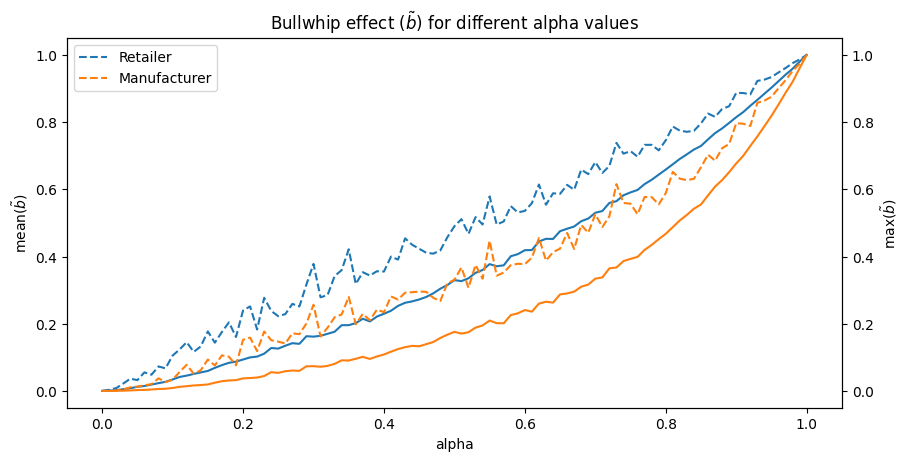

In [49]:
# Plot mean values of alpha
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
ax1.set_xlabel("alpha")

retailer_mean = [np.mean(bullwhip_effect[alpha, "retailer"]) for alpha in alpha_values]
manufacturer_mean = [
    np.mean(bullwhip_effect[alpha, "manufacturer"]) for alpha in alpha_values
]

ax1.plot(alpha_values, retailer_mean, label="Retailer")
ax1.plot(alpha_values, manufacturer_mean, label="Manufacturer")
ax1.set_ylabel(r"mean($\tilde{b}$)")

# Add second y-axis with max values
ax2 = ax1.twinx()

retailer_max = [np.max(bullwhip_effect[alpha, "retailer"]) for alpha in alpha_values]
manufacturer_max = [
    np.max(bullwhip_effect[alpha, "manufacturer"]) for alpha in alpha_values
]

ax2.plot(alpha_values, retailer_max, label="Retailer", linestyle="--")
ax2.plot(alpha_values, manufacturer_max, label="Manufacturer", linestyle="--")
ax2.set_ylabel(r"max($\tilde{b}$)")

plt.legend()
plt.title(r"Bullwhip effect ($\tilde{b}$) for different alpha values")


In the above graph we can see that we do not see a bullwhip effect for any alpha value. The reason for this is simple; the stage "managers" are rational, and thus do not over or under react to demand changes, which is what causes the bullwhip effect. The ratio $\tilde{b}$ is not significantly higher than 1, as a matter of fact the maximum $\tilde{b}$, which we get for $\alpha=1$ is because we are reacting exactly to the demand.